In [148]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import pickle
import tensorflow as tensor
from tensorflow.keras import optimizers
import warnings
warnings.filterwarnings("ignore")


In [2]:
df=pd.read_csv("C:/Users/panayyar/Documents/asess/complaints.csv")  #import dataset
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-07-26,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,33311,NaN,NaN,Web,2023-07-26,In progress,Yes,NaN,7304973
1,2023-07-26,"Payday loan, title loan, or personal loan",Title loan,Charged fees or interest you didn't expect,NaN,NaN,NaN,DFC Global Corp.,CA,92517,NaN,NaN,Web,2023-07-26,In progress,Yes,NaN,7299736
2,2023-07-25,Checking or savings account,Checking account,Managing an account,Banking errors,NaN,NaN,NAVY FEDERAL CREDIT UNION,CA,90008,NaN,NaN,Phone,2023-07-25,In progress,Yes,NaN,7300424
3,2023-07-25,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,NaN,NaN,NAVY FEDERAL CREDIT UNION,PA,19120,NaN,NaN,Referral,2023-07-25,In progress,Yes,NaN,7302242
4,2023-07-25,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,NaN,NaN,NAVY FEDERAL CREDIT UNION,WA,98520,NaN,NaN,Web,2023-07-25,In progress,Yes,NaN,7301655


In [3]:
df.shape

(3898716, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898716 entries, 0 to 3898715
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 535.

In [5]:
(df.isna().sum()/df.shape[0])*100  #to check missing values in dataset

Date received                    0.000000
Product                          0.000000
Sub-product                      6.035090
Issue                            0.000000
Sub-issue                       18.371254
Consumer complaint narrative    63.771252
Company public response         54.078856
Company                          0.000000
State                            1.084870
ZIP code                         0.774511
Tags                            89.378631
Consumer consent provided?      22.730381
Submitted via                    0.000000
Date sent to company             0.000000
Company response to consumer     0.000128
Timely response?                 0.000000
Consumer disputed?              80.292024
Complaint ID                     0.000000
dtype: float64

In [6]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [7]:
df["Consumer consent provided?"].value_counts()

Consent not provided    1458303
Consent provided        1413151
Other                    134082
Consent withdrawn          6987
Name: Consumer consent provided?, dtype: int64

In [8]:
df["Product"].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    2074862
Debt collection                                                                  496734
Mortgage                                                                         381097
Credit card or prepaid card                                                      199531
Checking or savings account                                                      175468
Credit reporting                                                                 140429
Credit card                                                                       89190
Bank account or service                                                           86205
Student loan                                                                      75423
Money transfer, virtual currency, or money service                                56854
Vehicle loan or lease                                                             45759
Consumer Loan                   

In [9]:
df["Product"].nunique()

18

In [10]:
df["Sub-product"].value_counts() #as this is contained in product can be removed

Credit reporting                              2054397
Checking account                               198780
General-purpose credit card or charge card     153165
I do not know                                  110433
Other debt                                      97703
                                               ...   
Credit repair                                     102
Traveler’s/Cashier’s checks                        88
Transit card                                       37
Student prepaid card                               31
Electronic Benefit Transfer / EBT card             12
Name: Sub-product, Length: 76, dtype: int64

In [11]:
df["Issue"].value_counts()

Incorrect information on your report                                                999447
Problem with a credit reporting company's investigation into an existing problem    561150
Improper use of your report                                                         488014
Attempts to collect debt not owed                                                   176681
Loan modification,collection,foreclosure                                            112306
                                                                                     ...  
Problem with an overdraft                                                                9
Lender damaged or destroyed vehicle                                                      8
Property was damaged or destroyed property                                               7
Lender sold the property                                                                 7
Lender damaged or destroyed property                                                     3

In [12]:
df["Issue"].nunique()

165

<Axes: ylabel='Issue'>

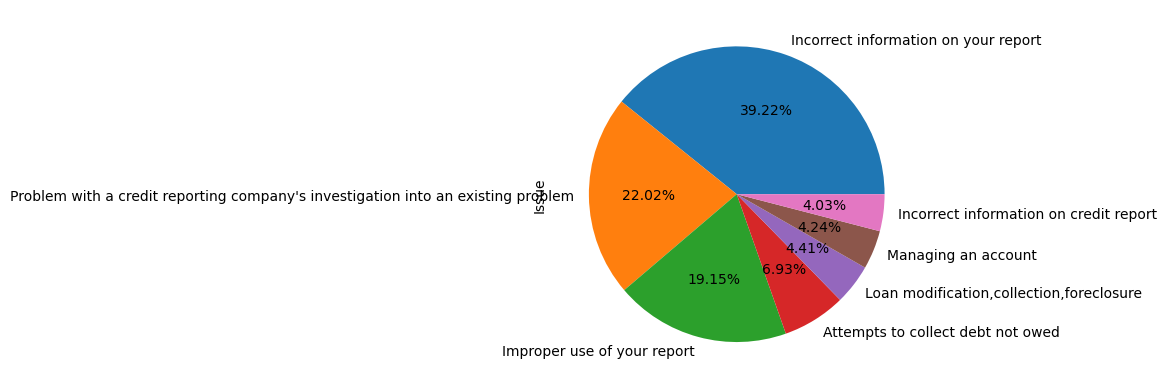

In [13]:
df["Issue"].value_counts().head(7).plot(kind="pie", autopct="%.2f%%")

In [14]:
df["Sub-issue"].nunique()

221

In [15]:
df["Sub-issue"].value_counts() #contained in issue so can be dropped

Information belongs to someone else                                                 651647
Reporting company used your report improperly                                       326352
Their investigation did not fix an error on your report                             322692
Credit inquiries on your report that you don't recognize                            157975
Investigation took more than 30 days                                                114220
                                                                                     ...  
Was signed up for overdraft on card, but don't want to be                                7
Insurance terms                                                                          6
Problem with a credit reporting company's investigation into an existing problem         3
Credit monitoring or identity theft protection services                                  1
Improper use of your report                                                              1

In [16]:
df["Consumer complaint narrative"].nunique()  #main feature containing complaints

1206569

In [17]:
df['Company public response'].nunique()  

11

In [18]:
df['Company public response'].value_counts()

Company has responded to the consumer and the CFPB and chooses not to provide a public response                            1565443
Company believes it acted appropriately as authorized by contract or law                                                    124815
Company chooses not to provide a public response                                                                             52473
Company believes the complaint is the result of a misunderstanding                                                           12177
Company disputes the facts presented in the complaint                                                                         9866
Company believes complaint caused principally by actions of third party outside the control or direction of the company       7466
Company believes complaint is the result of an isolated error                                                                 6032
Company believes complaint represents an opportunity for improvement to better serv

In [19]:
print(df["Company"].nunique())
print(df["Company"].value_counts())


6836
EQUIFAX, INC.                             732980
TRANSUNION INTERMEDIATE HOLDINGS, INC.    646163
Experian Information Solutions Inc.       595311
BANK OF AMERICA, NATIONAL ASSOCIATION     129325
WELLS FARGO & COMPANY                     117690
                                           ...  
Legal Recovery Specialists LLC                 1
STARK & STARK, P.C.                            1
Capital M Lending, LLC                         1
Blitz Ventures, LLC                            1
Mann & Carducci Co., LPA                       1
Name: Company, Length: 6836, dtype: int64


In [20]:
counts=df["Company"].value_counts()
count_1=counts[counts==1].index.tolist()

In [21]:
df["Company"]=df["Company"].replace(count_1,"Others")#replaced single vales with others

In [22]:
df["Tags"].value_counts()

Servicemember                    238653
Older American                   141345
Older American, Servicemember     34099
Name: Tags, dtype: int64

In [23]:
df["Company response to consumer"].value_counts()

Closed with explanation            2866820
Closed with non-monetary relief     733814
Closed with monetary relief         135954
In progress                         112074
Closed without relief                17868
Closed                               17611
Untimely response                     9266
Closed with relief                    5304
Name: Company response to consumer, dtype: int64

In [24]:
df['Submitted via'].nunique()

7

In [25]:
df["Company response to consumer"].nunique()

8

In [26]:
df["Consumer disputed?"].value_counts()

No     619980
Yes    148378
Name: Consumer disputed?, dtype: int64

In [27]:
df['Timely response?'].value_counts()

Yes    3845342
No       53374
Name: Timely response?, dtype: int64

In [28]:
df['Timely response?']=df['Timely response?'].map({"Yes":1,"No":0})

In [29]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [30]:
df["Consumer disputed?"].value_counts() 

No     619980
Yes    148378
Name: Consumer disputed?, dtype: int64

In [31]:
cols_drop=["Date received","Sub-product","Issue","Sub-issue","Company public response","Company","State","ZIP code","Tags","Consumer consent provided?","Date sent to company","Submitted via","Timely response?","Complaint ID","Consumer disputed?"]

unwanted columns to delete which as above

In [32]:
df1=df.drop(cols_drop,1)

In [33]:
df_new=df1.copy()
df_new.head()

,Product,Consumer complaint narrative,Company response to consumer
0,"Credit reporting, credit repair services, or o...",NaN,In progress
1,"Payday loan, title loan, or personal loan",NaN,In progress
2,Checking or savings account,NaN,In progress
3,Checking or savings account,NaN,In progress
4,Credit card or prepaid card,NaN,In progress


In [34]:
df_new.isnull().sum()

Product                               0
Consumer complaint narrative    2486260
Company response to consumer          5
dtype: int64

In [35]:
df_new.dropna(inplace=True)#removing missing values as  there are lots of records

In [36]:
df_new.isnull().sum()

Product                         0
Consumer complaint narrative    0
Company response to consumer    0
dtype: int64

In [37]:
df_new.head()

,Product,Consumer complaint narrative,Company response to consumer
5,"Credit reporting, credit repair services, or o...",I looked over my credit report and saw some in...,Closed with explanation
28,Credit card or prepaid card,credit card was settled on XX/XX/2022 for the ...,Closed with explanation
243,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX XXXX is reporting an account wi...,Closed with non-monetary relief
634,Mortgage,Im relocation to XXXX I got transferred from m...,Closed with explanation
938,"Credit reporting, credit repair services, or o...",I have identified inquiries on my report are n...,Closed with explanation


In [38]:
df_new.shape

(1412454, 3)

In [39]:
df_new=df_new.drop_duplicates()

In [40]:
data = df_new.sample(10000, random_state=42).copy()
data.head()

,Product,Consumer complaint narrative,Company response to consumer
1475344,"Credit reporting, credit repair services, or o...",This company has been notified on multiple occ...,Closed with explanation
3324754,Debt collection,On XXXX XXXX 2017 I faxed a letter r...,Closed with explanation
1009716,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...,Closed with non-monetary relief
1761039,Debt collection,Pressler & Pressler took 100 % of the funds fr...,Closed with explanation
2770959,"Credit reporting, credit repair services, or o...","Transunion, XXXX, and XXXX continue to fail to...",Closed with non-monetary relief


In [41]:
print(data['Product'].nunique())
data['Product'].unique()

17


array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Student loan', 'Checking or savings account',
       'Money transfer, virtual currency, or money service',
       'Credit card', 'Mortgage', 'Credit card or prepaid card',
       'Vehicle loan or lease', 'Credit reporting', 'Consumer Loan',
       'Bank account or service',
       'Payday loan, title loan, or personal loan', 'Money transfers',
       'Payday loan', 'Prepaid card', 'Other financial service'],
      dtype=object)

In [42]:
prod_dict={'Credit card': 'Credit card or prepaid card',
    'Prepaid card': 'Credit card or prepaid card',
    'Payday loan': 'Payday loan, title loan, or personal loan',
    'Money transfer': 'Money transfer, virtual currency, or money service',
    'Virtual currency': 'Money transfer, virtual currency, or money service',
    'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, credit repair, or other', 
    'Credit reporting': 'Credit reporting, credit repair, or other'
    }

In [43]:
data.replace({'Product':prod_dict}, inplace= True)

In [44]:
print(data['Product'].nunique())
data['Product'].unique()

13


array(['Credit reporting, credit repair, or other', 'Debt collection',
       'Student loan', 'Checking or savings account',
       'Money transfer, virtual currency, or money service',
       'Credit card or prepaid card', 'Mortgage', 'Vehicle loan or lease',
       'Consumer Loan', 'Bank account or service',
       'Payday loan, title loan, or personal loan', 'Money transfers',
       'Other financial service'], dtype=object)

In [45]:
data.head(7)

,Product,Consumer complaint narrative,Company response to consumer
1475344,"Credit reporting, credit repair, or other",This company has been notified on multiple occ...,Closed with explanation
3324754,Debt collection,On XXXX XXXX 2017 I faxed a letter r...,Closed with explanation
1009716,"Credit reporting, credit repair, or other",In accordance with the Fair Credit Reporting a...,Closed with non-monetary relief
1761039,Debt collection,Pressler & Pressler took 100 % of the funds fr...,Closed with explanation
2770959,"Credit reporting, credit repair, or other","Transunion, XXXX, and XXXX continue to fail to...",Closed with non-monetary relief
3723784,"Credit reporting, credit repair, or other",I HAVE NEW UPDATED INFORMATION! \nI am XXXX XX...,Closed with explanation
3740210,"Credit reporting, credit repair, or other",Every time I try to access my account online u...,Closed with explanation


In [46]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data["Product_id"]=encoder.fit_transform(data["Product"])

In [47]:
data.shape

(10000, 4)

In [48]:
prod_group=data.groupby('Product')['Consumer complaint narrative'].count().sort_values()

<Axes: title={'center': 'Complaints for each Product'}, ylabel='Product'>

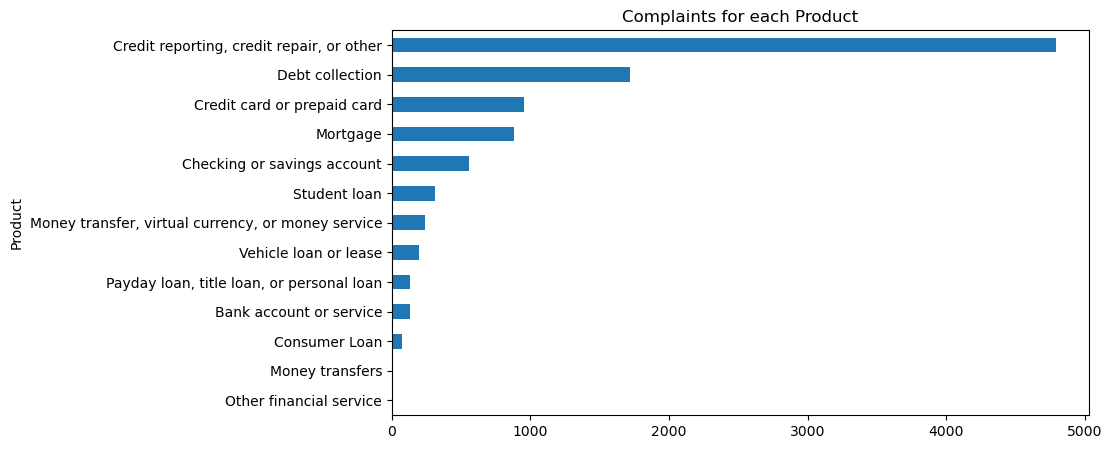

In [49]:
fig = plt.figure(figsize=(9,5))
prod_group.plot.barh( title= 'Complaints for each Product')


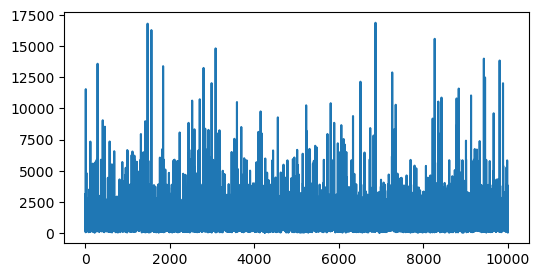

In [50]:
fig = plt.figure(figsize=(6,3))
len_complaint = [len(x) for x in data['Consumer complaint narrative']]
plt.plot(len_complaint)

In [51]:
def preprocess_text(text_data):#method to preprocess text data
   
    text_data = text_data.lower()#lowering text
    text_data = re.sub(r'[^\w\s]', '', text_data)#removing special characters
    tokens = nltk.word_tokenize(text_data)#creating word tokens
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text



In [52]:
data["Consumer complaint narrative"]=data["Consumer complaint narrative"].apply(preprocess_text)

In [53]:
data.head()

,Product,Consumer complaint narrative,Company response to consumer,Product_id
1475344,"Credit reporting, credit repair, or other",this company has been notified on multiple occ...,Closed with explanation,4
3324754,Debt collection,on xxxx xxxx 2017 i faxed a letter requesting ...,Closed with explanation,5
1009716,"Credit reporting, credit repair, or other",in accordance with the fair credit reporting a...,Closed with non-monetary relief,4
1761039,Debt collection,pressler pressler took 100 of the funds from t...,Closed with explanation,5
2770959,"Credit reporting, credit repair, or other",transunion xxxx and xxxx continue to fail to d...,Closed with non-monetary relief,4


In [54]:
data.columns

Index(['Product', 'Consumer complaint narrative',
       'Company response to consumer', 'Product_id'],
      dtype='object')

In [55]:
text_cols=data[['Consumer complaint narrative',"Company response to consumer"]]#important columns
text_cols.head()

,Consumer complaint narrative,Company response to consumer
1475344,this company has been notified on multiple occ...,Closed with explanation
3324754,on xxxx xxxx 2017 i faxed a letter requesting ...,Closed with explanation
1009716,in accordance with the fair credit reporting a...,Closed with non-monetary relief
1761039,pressler pressler took 100 of the funds from t...,Closed with explanation
2770959,transunion xxxx and xxxx continue to fail to d...,Closed with non-monetary relief


In [56]:
text_cols.shape

(10000, 2)

In [57]:
tfidf = TfidfVectorizer()
tf=tfidf.fit(data['Consumer complaint narrative']+""+data["Company response to consumer"])
X_tfidf=tf.transform(data['Consumer complaint narrative']+""+data["Company response to consumer"]).toarray()



In [58]:
X_tfidf.shape

(10000, 23425)

In [59]:
prod_dict=dict(data[["Product","Product_id"]].values) 
sort_dict=sorted(prod_dict.items())

In [60]:
df_prod=pd.DataFrame(sort_dict,columns=["Product","Id"])
df_prod=df_prod.set_index("Id")


In [61]:
df_prod

,Product
Id,
0,Bank account or service
1,Checking or savings account
2,Consumer Loan
3,Credit card or prepaid card
4,"Credit reporting, credit repair, or other"
5,Debt collection
6,"Money transfer, virtual currency, or money ser..."
7,Money transfers
8,Mortgage


In [62]:
labels=data["Product_id"]  #checking correlation
for Product, Product_id in sort_dict:
    features = chi2(X_tfidf, labels)
    indices = np.argsort(features[0])
    feature_name = np.array(tfidf.get_feature_names_out())[indices]
    print(feature_name)
  

['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexington']
['37293733' 'chargeoffsloans' 'aggravaled' ... 'mortgage' 'cordially'
 'lexi

In [63]:
data.head(4)

,Product,Consumer complaint narrative,Company response to consumer,Product_id
1475344,"Credit reporting, credit repair, or other",this company has been notified on multiple occ...,Closed with explanation,4
3324754,Debt collection,on xxxx xxxx 2017 i faxed a letter requesting ...,Closed with explanation,5
1009716,"Credit reporting, credit repair, or other",in accordance with the fair credit reporting a...,Closed with non-monetary relief,4
1761039,Debt collection,pressler pressler took 100 of the funds from t...,Closed with explanation,5


In [89]:
X=X_tfidf 
y = data['Product'] 


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state = 42)

In [91]:
model=LogisticRegression()#baseline model
model.fit(X_train,y_train)
y_pred=model.predict(X_test)


In [92]:
print(metrics.classification_report(y_test, y_pred))

                                                    precision    recall  f1-score   support

                           Bank account or service       0.00      0.00      0.00        23
                       Checking or savings account       0.64      0.71      0.67       122
                                     Consumer Loan       0.00      0.00      0.00        19
                       Credit card or prepaid card       0.71      0.72      0.72       247
         Credit reporting, credit repair, or other       0.81      0.92      0.86      1218
                                   Debt collection       0.76      0.71      0.74       437
Money transfer, virtual currency, or money service       0.95      0.36      0.52        53
                                   Money transfers       0.00      0.00      0.00         1
                                          Mortgage       0.80      0.87      0.83       217
         Payday loan, title loan, or personal loan       0.50      0.03      0.

<Axes: >

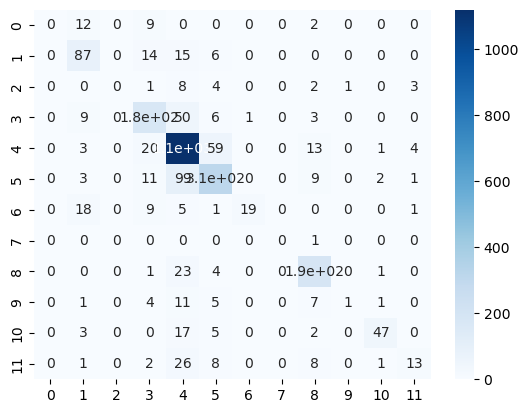

In [94]:
conf_mat=metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True,cmap="Blues")

In [95]:
ml_models = [RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    LinearSVC(),
    MultinomialNB(),
   lgb.LGBMClassifier()
             
]



In [96]:
cv=3
result_df = pd.DataFrame(index=range(cv*len(ml_models)))
results= []
for model in ml_models:
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    for fold_num, accu_val in enumerate(scores):
        results.append((model, fold_num, accu_val))
cv_df = pd.DataFrame(results, columns=['ML_Model', 'fold_num', 'accuracy'])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136066
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 2639
[LightGBM] [Info] Start training from score -4.350428
[LightGBM] [Info] Start training from score -2.891272
[LightGBM] [Info] Start training from score -4.912955
[LightGBM] [Info] Start training from score -2.346437
[LightGBM] [Info] Start training from score -0.735746
[LightGBM] [Info] Start training from score -1.760742
[LightGBM] [Info] Start training from score -3.723371
[LightGBM] [Info] Start training from score -6.858865
[LightGBM] [Info] Start training from score -2.428048
[LightGBM] [Info] Start training from score -4.316139
[LightGBM] [Info] Start training from score -3.476899
[LightGBM] [Info] Start training from score -3.921973
[LightGBM] [Warning] No further splits with positive gain

In [97]:
max_idx=cv_df["accuracy"].argmax()
best_model=cv_df.iloc[max_idx]["ML_Model"]
best_model
# so best model from cv_df is LinearSVC()

LinearSVC()

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state = 42)#train test split with test size as 0.25

In [99]:
param_grid = { 'C': [0.01, 0.1, 1.0, 10.0],  #tuning Linear svc model to chose best parameter
              'penalty': ['l1', 'l2'],
           }
grid= GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy',verbose = 3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.6s
[CV 2/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.6s
[CV 3/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.6s
[CV 4/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.5s
[CV 5/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.5s
[CV 1/5] END ................C=0.01, penalty=l2;, score=0.625 total time=   1.3s
[CV 2/5] END ................C=0.01, penalty=l2;, score=0.627 total time=   1.3s
[CV 3/5] END ................C=0.01, penalty=l2;, score=0.643 total time=   1.3s
[CV 4/5] END ................C=0.01, penalty=l2;, score=0.621 total time=   1.3s
[CV 5/5] END ................C=0.01, penalty=l2;, score=0.616 total time=   1.3s
[CV 1/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.5s
[CV 2/5] END ...................C=0.1, penalty=l1

# LinearSVC

In [100]:
svc_model=grid.best_estimator_ #model tuned wth best params from above
svc_model

LinearSVC()

In [101]:
svc_model.fit(X_train, y_train)
y_pred_m = svc_model.predict(X_test)

In [77]:
y_test

3555248     5
307532      8
2327800     4
2824375    11
455926      4
           ..
3588243     4
2858351    11
3495649     4
1833313     3
2321189     4
Name: Product_id, Length: 2500, dtype: int32

In [102]:
print(metrics.classification_report(y_test, y_pred_m))

                                                    precision    recall  f1-score   support

                           Bank account or service       0.33      0.04      0.08        23
                       Checking or savings account       0.66      0.72      0.69       122
                                     Consumer Loan       0.67      0.11      0.18        19
                       Credit card or prepaid card       0.69      0.73      0.71       247
         Credit reporting, credit repair, or other       0.85      0.89      0.87      1218
                                   Debt collection       0.75      0.72      0.74       437
Money transfer, virtual currency, or money service       0.88      0.57      0.69        53
                                   Money transfers       0.00      0.00      0.00         1
                                          Mortgage       0.83      0.90      0.86       217
         Payday loan, title loan, or personal loan       0.56      0.17      0.

<Axes: >

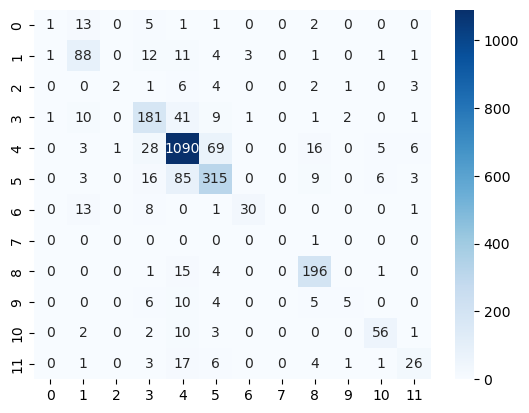

In [103]:
conf_mat=metrics.confusion_matrix(y_test, y_pred_m)
sns.heatmap(conf_mat, annot=True,cmap="Blues",fmt='d')

In [104]:
complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""


In [106]:
df_prod

,Product
Id,
0,Bank account or service
1,Checking or savings account
2,Consumer Loan
3,Credit card or prepaid card
4,"Credit reporting, credit repair, or other"
5,Debt collection
6,"Money transfer, virtual currency, or money ser..."
7,Money transfers
8,Mortgage


In [127]:
new_matrix = tf.transform([complaint])  #for testing
p=svc_model.predict(new_matrix)
result=" ".join(p)
print(result)





Student loan


So the model is predicting good results.

In [128]:
with open('model_get_product.pkl', 'wb') as file:
    pickle.dump(svc_model, file)#saving model into pickle file

In [129]:
def classify_product(complaint,model_path='model_get_product.pkl'):#main function to classify product on basis of complaints
    try:
            
        model=pickle.load(open(model_path, 'rb'))   #load saved svc model
        new_tfidf_matrix = tf.transform([complaint])#tfidf vectoriser transformed above
        prod_id=model.predict(new_tfidf_matrix)
        product=" ".join(prod_id)
        return product
    
    except Exception as e:
        print("Error:", str(e))
        return None

In [130]:
comp="""Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
classify_product(comp)

'Credit reporting, credit repair, or other'

# CNN model

In [168]:
X_c=data['Consumer complaint narrative']
y_c=data["Product_id"]

For deep learning model i have taken just Consumer Complaint narrative as X column.

In [169]:
X_train_cn, X_test_cn, y_train_cn, y_test_cn = train_test_split(X_c,y_c, test_size=0.25)



In [170]:
tokenizer = tensor.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_cn)
X_train_cnn = tokenizer.texts_to_sequences(X_train_cn)
X_test_cnn = tokenizer.texts_to_sequences(X_test_cn)


In [171]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 100
X_train_padded = pad_sequences(X_train_cnn, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_cnn, maxlen=maxlen)




In [172]:
X_train_padded.shape

(7500, 100)

In [173]:
X_test_padded.shape

(2500, 100)

In [174]:
# Create a CNN model
model = tensor.keras.Sequential([
    tensor.keras.layers.Embedding(input_dim=10000, output_dim=128),#embedding layer
    tensor.keras.layers.Conv1D(filters=128, kernel_size=9, activation='relu'),  #convultion
    tensor.keras.layers.MaxPooling1D(pool_size=2),  #pooling layer
    tensor.keras.layers.GlobalMaxPooling1D(),
    tensor.keras.layers.Flatten(),#flattening 
    tensor.keras.layers.Dense(128, activation='relu'),
    tensor.keras.layers.Dropout(0.1),#dropout layer to add regularisation
    tensor.keras.layers.Dense(13, activation='softmax')#softmax is the activation unit in output layer with 13 units
])


In [175]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         147584    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [176]:
from tensorflow.keras.utils import to_categorical 
y_train_cnn_encoded = to_categorical(y_train_cn, num_classes=13)
history=model.fit(X_train_padded, y_train_cnn_encoded, epochs=10)




Epoch 1/10
235/235 [==============================] - 8s 29ms/step - loss: 1.3922 - accuracy: 0.5655
Epoch 2/10
235/235 [==============================] - 7s 29ms/step - loss: 0.8848 - accuracy: 0.7207
Epoch 3/10
235/235 [==============================] - 7s 28ms/step - loss: 0.5865 - accuracy: 0.8167
Epoch 4/10
235/235 [==============================] - 7s 28ms/step - loss: 0.3208 - accuracy: 0.9097
Epoch 5/10
235/235 [==============================] - 7s 28ms/step - loss: 0.1628 - accuracy: 0.9576
Epoch 6/10
235/235 [==============================] - 7s 29ms/step - loss: 0.0886 - accuracy: 0.9837
Epoch 7/10
235/235 [==============================] - 7s 29ms/step - loss: 0.0489 - accuracy: 0.9937
Epoch 8/10
235/235 [==============================] - 7s 30ms/step - loss: 0.0356 - accuracy: 0.9955
Epoch 9/10
235/235 [==============================] - 9s 40ms/step - loss: 0.0199 - accuracy: 0.9971
Epoch 10/10
235/235 [==============================] - 14s 62ms/step - loss: 0.0216 - accur

In [177]:
from tensorflow.keras.utils import to_categorical 
y_test_cnn_encoded = to_categorical(y_test_cn, num_classes=13)


In [178]:
# Evaluate the model
loss, accuracy =model.evaluate(X_test_padded, y_test_cnn_encoded)
print("Accuracy",accuracy*100)

79/79 [==============================] - 1s 12ms/step - loss: 1.2549 - accuracy: 0.7428
Accuracy 74.27999973297119


In [179]:
pred_cnn=model.predict(X_test_padded)
pred_cnn.shape


79/79 [==============================] - 1s 6ms/step


(2500, 13)

In [180]:
complaint ="""Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""


In [182]:
tokenizer = tensor.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts([complaint])
text_seq= tokenizer.texts_to_sequences(complaint)
padded_seq=pad_sequences(text_seq, maxlen=100)

In [181]:
sorted(prod_dict.keys())

['Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card or prepaid card',
 'Credit reporting, credit repair, or other',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Money transfers',
 'Mortgage',
 'Other financial service',
 'Payday loan, title loan, or personal loan',
 'Student loan',
 'Vehicle loan or lease']

In [183]:
pred=model.predict(padded_seq)

class_labels =['Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card or prepaid card',
 'Credit reporting, credit repair, or other',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Money transfers',
 'Mortgage',
 'Other financial service',
 'Payday loan, title loan, or personal loan',
 'Student loan',
 'Vehicle loan or lease']

# List of class labels used during training
predicted_index = tensor.argmax(pred, axis=1).numpy()[0]
# print(predicted_index)
predicted_class_label = class_labels[predicted_index]

print("Predicted class:", predicted_class_label)

8/8 [==============================] - 0s 7ms/step
Predicted class: Credit reporting, credit repair, or other


I have just used CNN model here as assignment task.Main model would be LinearSVC as above.